# Curve Fitting $Y(A,TKE)$ with scipy

Websites of interest
https://stackoverflow.com/questions/35990467/fit-two-gaussians-to-a-histogram-from-one-set-of-data-python

In [50]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
import pylab as pl
%matplotlib inline

In [51]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


40401
<class 'numpy.ndarray'>
<class 'numpy.float64'>


/home/austinlc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/home/austinlc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


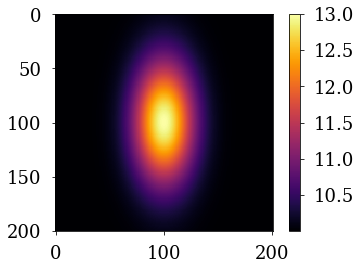

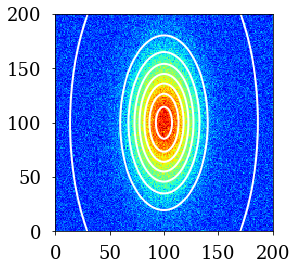

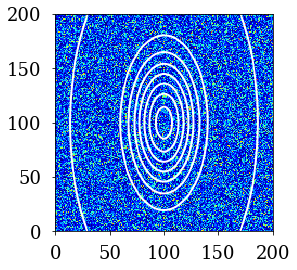

[  2.99893857e+00   1.00044513e+02   9.98722634e+01   2.00498830e+01
   4.00070032e+01   2.26426829e-03   9.99971873e+00] 
 [ 0.005648    0.03762071  0.07525992  0.04159833  0.08229949  0.00178047
  0.00134319]


In [101]:
def twoD_Gaussian(tup1, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x,y = tup1
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))

    return g.ravel()

# Create x and y indices
x = np.linspace(0, 200, 201)
y = np.linspace(0, 200, 201)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 3, 100, 100, 20, 40, 0, 10)
print(len(data))
print(type(data))

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(201, 201))
plt.colorbar()

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

data_noisy = data + 0.2*np.random.normal(size=data.shape)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)

data_fitted = twoD_Gaussian((x, y), *popt)
print(type(data_fitted[1]))

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(np.abs(data_noisy.reshape(201, 201) - data_fitted.reshape(201, 201)), cmap=plt.cm.jet, origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')
plt.show()

sigma=np.sqrt(np.diag(pcov))

print(popt,'\n',sigma)    

In [53]:
#get yield data
f=open(os.path.join(os.getcwd(),'yieldsATKE.Cf252.sf.dat3'),"r")
lines=f.readlines()
YATKE_data=[]
for x in lines:
    x = x.split()
    if len(x) != 0:
        YATKE_data.append(x[2])
f.close()

#convert from strings to ints
YATKE_data = list(map(int, YATKE_data))

total = sum(YATKE_data)
#normalize yield data
YATKE_data = np.asarray([float(i)/total for i in YATKE_data])

In [54]:
def gauss(x,mu,sigma,w):
    return w/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,w1,mu2,sigma2,w2):
    return gauss(x,mu1,sigma1,w1)+gauss(x,mu2,sigma2,w2)

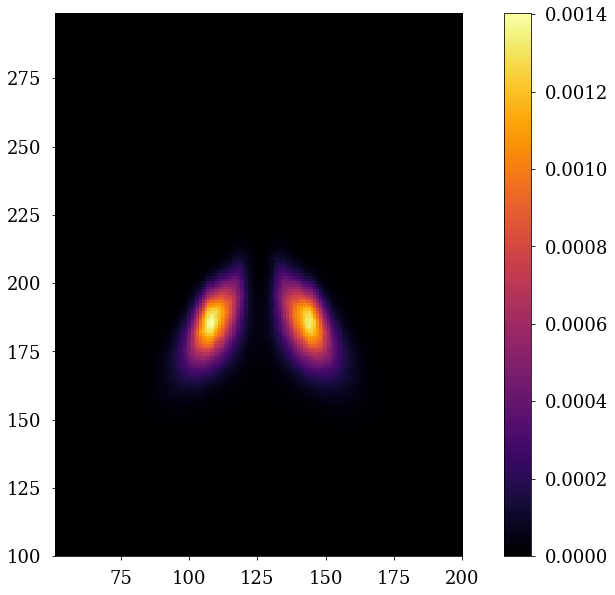

In [55]:
# Cf 252 -------------------------

# define A
A = np.linspace(51,200,150)

# define TKE
TKE = np.linspace(100,299,200)

# define the model
# this model is with 3 modes, S1, S2, and SL. In future, expand to higher modes
def YATKE_3(tuple_in, A_bar_S1, sig_a_S1, w_S1, A_bar_S2, sig_a_S2, w_S2, A_bar_SL, sig_a_SL, w_SL, TKE_bar, sig_TKE , w_TKE):
    
    #unpack the tuple
    A, TKE = tuple_in
    
    # due to pure symmetry of the pre-fission distribution of fragment mass: Y(A), we can assume
    A_bar_S1_H = 252. - A_bar_S1
    A_bar_S2_H = 252. - A_bar_S2
    
    # assume the weights and the variances are the same for paired fragment
    
    Y = []
    for i in range(len(TKE)):
        for j in range(len(A)):
            #order light S1, light S2, SL, heavy S1, heavy S2, TKE
            Y.append(gauss(A[j], A_bar_S1, sig_a_S1, w_S1) + \
                    gauss(A[j], A_bar_S2, sig_a_S2, w_S2) + \
                    gauss(A[j], A_bar_SL, sig_a_SL, w_SL) + \
                    gauss(A[j], A_bar_S1_H, sig_a_S1, w_S1) + \
                    gauss(A[j], A_bar_S2_H, sig_a_S2, w_S2) + \
                    gauss(TKE[i], TKE_bar, sig_TKE, w_TKE))
    return np.asarray(Y)
    
fig, axes = pl.subplots(1, 1, figsize=(15, 10))
plt.imshow(np.transpose(YATKE_data.reshape(150, 200)), extent=[51,200, 100,299], origin="lower")
plt.colorbar()


# CURVE FIT

# initial_guess = (107.9, 3.13, 0.11, 100.9, 5.11, 0.8, 126, 15, 0.01, 185, 10, 0.5)

# popt, pcov = opt.curve_fit(YATKE_3, (A, TKE), YATKE_data, p0=initial_guess)

# data_fitted = twoD_Gaussian((A, TKE), *popt)

# fig, ax = plt.subplots(1, 1)
# ax.hold(True)
# ax.imshow(YATKE_data.reshape(150, 200), cmap=plt.cm.jet, origin='bottom',
#     extent=(A.min(), A.max(), TKE.min(), TKE.max()))
# ax.contour(x, y, data_fitted.reshape(150, 200), 8, colors='w')
# plt.show()

# sigma=np.sqrt(np.diag(pcov))

# print(popt,'\n',sigma)  

# U-235

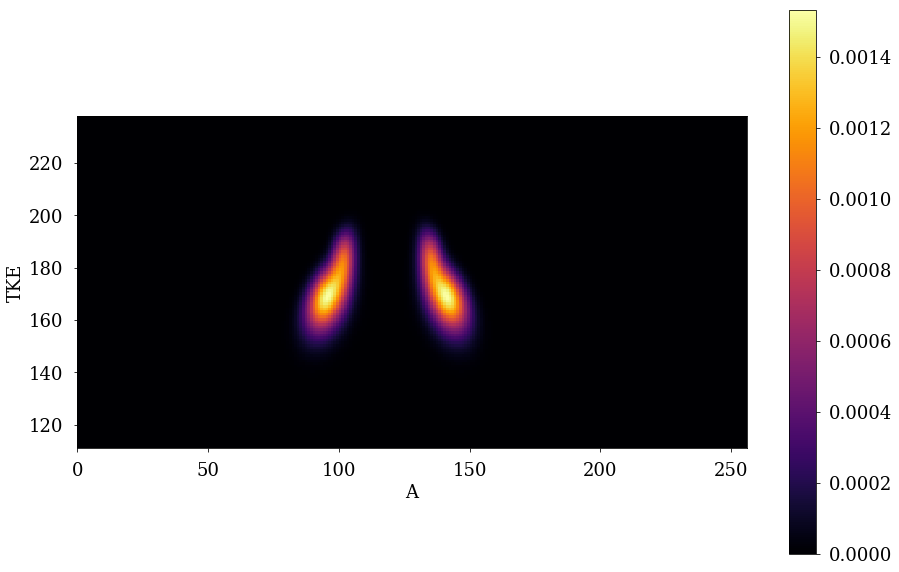

In [56]:
#get yield data
f=open(os.path.join(os.getcwd(),'tkm0.5-sum.dat'),"r")
lines=f.readlines()
YATKE_data_U235_sum=[]
for x in lines:
    x = x.split()
    for y in range(len(x)):
        if len(x) != 0:
            YATKE_data_U235_sum.append(x[y])
f.close()
for i in range(5): YATKE_data_U235_sum.pop(0)

#convert from strings to floats
YATKE_data_U235_sum = list(map(float, YATKE_data_U235_sum))
#norm
total_sum = sum(YATKE_data_U235_sum)
YATKE_data_U235_sum = np.asarray([float(i)/total_sum for i in YATKE_data_U235_sum])

YATKE_data_U235_sum = np.transpose(np.asarray(YATKE_data_U235_sum).reshape(256, 128))
fig, axes = pl.subplots(1, 1, figsize=(15, 10))
c1 = plt.imshow(YATKE_data_U235_sum, extent=[0,256, 111,238], origin="lower")
pl.colorbar(c1);
plt.xlabel('A')
plt.ylabel('TKE')

In [57]:
#get yield data
f=open(os.path.join(os.getcwd(),'tkm0.5-s1.dat'),"r")
lines=f.readlines()
YATKE_data_U235_s1=[]
for x in lines:
    x = x.split()
    for y in range(len(x)):
        if len(x) != 0:
            YATKE_data_U235_s1.append(x[y])
f.close()
for i in range(5): YATKE_data_U235_s1.pop(0)

#convert from strings to floats
YATKE_data_U235_s1 = list(map(float, YATKE_data_U235_s1))
#norm
total_s1 = sum(YATKE_data_U235_s1)
YATKE_data_U235_s1 = np.asarray([float(i)/total_s1 for i in YATKE_data_U235_s1])

YATKE_data_U235_s1 = np.transpose(np.asarray(YATKE_data_U235_s1).reshape(256, 128))

In [58]:
#get yield data
f=open(os.path.join(os.getcwd(),'tkm0.5-s2.dat'),"r")
lines=f.readlines()
YATKE_data_U235_s2=[]
for x in lines:
    x = x.split()
    for y in range(len(x)):
        if len(x) != 0:
            YATKE_data_U235_s2.append(x[y])
f.close()
for i in range(5): YATKE_data_U235_s2.pop(0)

#convert from strings to floats
YATKE_data_U235_s2 = list(map(float, YATKE_data_U235_s2))
#norm
total_s2 = sum(YATKE_data_U235_s2)
YATKE_data_U235_s2 = np.asarray([float(i)/total_s2 for i in YATKE_data_U235_s2])

YATKE_data_U235_s2 = np.transpose(np.asarray(YATKE_data_U235_s2).reshape(256, 128))

In [59]:
#get yield data
f=open(os.path.join(os.getcwd(),'tkm0.5-sl.dat'),"r")
lines=f.readlines()
YATKE_data_U235_sl=[]
for x in lines:
    x = x.split()
    for y in range(len(x)):
        if len(x) != 0:
            YATKE_data_U235_sl.append(x[y])
f.close()
for i in range(5): YATKE_data_U235_sl.pop(0)

#convert from strings to floats
YATKE_data_U235_sl = list(map(float, YATKE_data_U235_sl))
#norm
total_sl = sum(YATKE_data_U235_sl)
YATKE_data_U235_sl = np.asarray([float(i)/total_sl for i in YATKE_data_U235_sl])

YATKE_data_U235_sl = np.transpose(np.asarray(YATKE_data_U235_sl).reshape(256, 128))

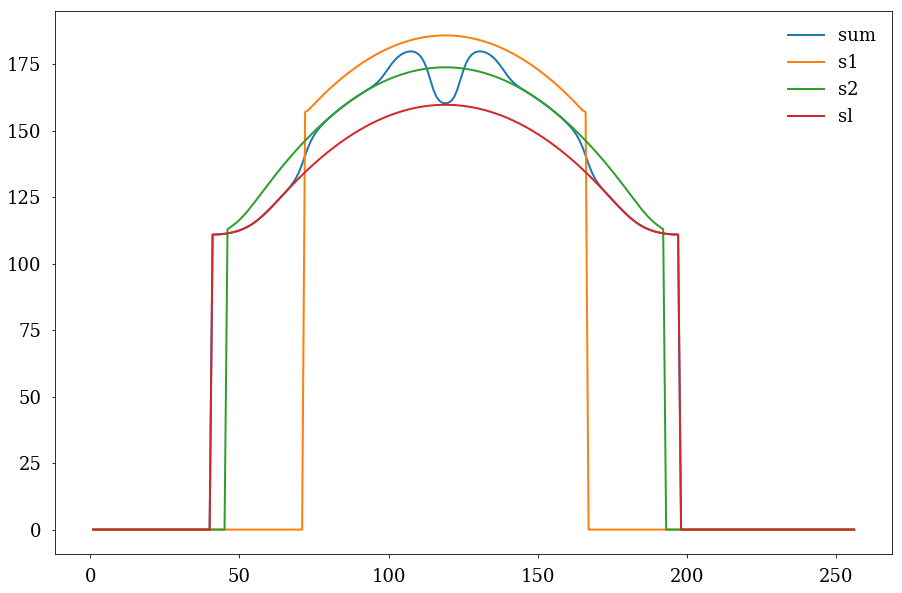

In [60]:
A = np.linspace(1,256,256)
TKE = np.linspace(111,238, 128)

TKEA_sum = np.zeros(len(A))
TKEA_s1 = np.zeros(len(A))
TKEA_s2 = np.zeros(len(A))
TKEA_sl = np.zeros(len(A))
varTKEA_sum = np.zeros(len(A))
varTKEA_s1 = np.zeros(len(A))
varTKEA_s2 = np.zeros(len(A))
varTKEA_sl = np.zeros(len(A))

for i in range(len(A)):
    if sum(YATKE_data_U235_sum[:,i]) != 0 :
        TKEA_sum[i] = sum(np.multiply(TKE , YATKE_data_U235_sum[:,i]/sum(YATKE_data_U235_sum[:,i])))
        varTKEA_sum[i] = sum(np.multiply(np.square(TKE) , YATKE_data_U235_sum[:,i]/sum(YATKE_data_U235_sum[:,i]))) - np.square(TKEA_sum[i])
    if sum(YATKE_data_U235_s1[:,i]) != 0 :
        TKEA_s1[i] = sum(np.multiply(TKE , YATKE_data_U235_s1[:,i]/sum(YATKE_data_U235_s1[:,i])))
        varTKEA_s1[i] = sum(np.multiply(np.square(TKE) , YATKE_data_U235_s1[:,i]/sum(YATKE_data_U235_s1[:,i]))) - np.square(TKEA_sum[i])
    if sum(YATKE_data_U235_s2[:,i]) != 0 :
        TKEA_s2[i] = sum(np.multiply(TKE , YATKE_data_U235_s2[:,i]/sum(YATKE_data_U235_s2[:,i])))
        varTKEA_s2[i] = sum(np.multiply(np.square(TKE) , YATKE_data_U235_s2[:,i]/sum(YATKE_data_U235_s2[:,i]))) - np.square(TKEA_sum[i])
    if sum(YATKE_data_U235_sl[:,i]) != 0 :
        TKEA_sl[i] = sum(np.multiply(TKE , YATKE_data_U235_sl[:,i]/sum(YATKE_data_U235_sl[:,i])))
        varTKEA_sl[i] = sum(np.multiply(np.square(TKE) , YATKE_data_U235_sl[:,i]/sum(YATKE_data_U235_sl[:,i]))) - np.square(TKEA_sum[i])

fig, axes = pl.subplots(1, 1, figsize=(15, 10))
plt.plot(A, TKEA_sum, label = 'sum')
plt.plot(A, TKEA_s1, label = 's1')
plt.plot(A, TKEA_s2, label = 's2')
plt.plot(A, TKEA_sl, label = 'sl')

lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)

In [61]:
def get_TKEA(instr, selection = 0):
    #i = 0 returns TKE(A)
    #i = 1 returns sig
    # instr = 's1' 's2' or 'sl' or 'sum'
    
    #get yield data
    f=open(os.path.join(os.getcwd(),'tkm0.5-'+ instr + '.dat'),"r")
    lines=f.readlines()
    YATKE_data_U235=[]
    for x in lines:
        x = x.split()
        for y in range(len(x)):
            if len(x) != 0:
                YATKE_data_U235.append(x[y])
    f.close()
    for i in range(5): YATKE_data_U235.pop(0)

    #convert from strings to floats
    YATKE_data_U235 = list(map(float, YATKE_data_U235))
    #norm
    total = sum(YATKE_data_U235)
    YATKE_data_U235 = np.asarray([float(i)/total for i in YATKE_data_U235])
    
    YATKE_data_U235 = np.transpose(np.asarray(YATKE_data_U235).reshape(256, 128))
    
    A = np.linspace(1,256,256)
    TKE = np.linspace(111,238, 128)
    
    TKEA = np.zeros(len(A))
    varTKEA = np.zeros(len(A))
    
    for i in range(len(A)):
        varTKEA[i] = np.inf
        if sum(YATKE_data_U235[:,i]) != 0 :
            TKEA[i] = sum(np.multiply(TKE , YATKE_data_U235[:,i]/sum(YATKE_data_U235[:,i])))
            varTKEA[i] = sum(np.multiply(np.square(TKE) , YATKE_data_U235[:,i]/sum(YATKE_data_U235[:,i]))) - np.square(TKEA[i])
        
    if (selection == 0):
        return TKEA #return TKE(A) -- default
    if (selection == 1):
        return np.sqrt(varTKEA) #return sig

In [73]:
# curve fitting

# define the model
# this model is with 3 modes, S1, S2, and SL. In future, expand to higher modes
def YATKE_U235(tuple_in, A_bar_S1, sig_a_S1, w_S1, A_bar_S2, sig_a_S2, w_S2, A_bar_SL, sig_a_SL, w_SL):
    
    #unpack the tuple
    A, TKE = tuple_in
    
    # due to pure symmetry of the pre-fission distribution of fragment mass: Y(A), we can assume
    A_bar_S1_H = 236. - A_bar_S1
    A_bar_S2_H = 236. - A_bar_S2
    
    # assume the weights and the variances are the same for paired fragment
    
    Y = [] # yield list that will be returned
    
    #get the TKEA data from file
    
    TKEA_S1 = get_TKEA('s1')
    TKEA_S2 = get_TKEA('s2')
    TKEA_SL = get_TKEA('sl')
    TKEA_sum = get_TKEA('sum')
    
    sigTKEA_S1 = get_TKEA('s1', 1)
    sigTKEA_S2 = get_TKEA('s2', 1)
    sigTKEA_SL = get_TKEA('sl', 1)
    sigTKEA_sum = get_TKEA('sum', 1)
    
    
    for i in range(len(A)):
        for j in range(len(TKE)):
            #order light S1, light S2, SL, heavy S1, heavy S2, TKE
            Y.append(bimodal(A[i], A_bar_S1, sig_a_S1, w_S1, A_bar_S1_H, sig_a_S1, w_S1) * \
                     gauss(TKE[j], TKEA_sum[i], sigTKEA_sum[i], w_S1) + \
                    bimodal(A[i], A_bar_S2, sig_a_S2, w_S2, A_bar_S2_H, sig_a_S2, w_S2) * \
                     gauss(TKE[j], TKEA_sum[i], sigTKEA_sum[i], w_S2) + \
                    gauss(A[i], A_bar_SL, sig_a_SL, w_SL) * \
                     gauss(TKE[j], TKEA_sum[i], sigTKEA_sum[i], w_SL))
    return np.asarray(Y)


# CURVE FIT

initial_guess = (101.5814, 3.1326, 0.11, 95.1147, 5.1109, 0.8, 118., 15., 0.1)
A = np.linspace(1,256,256)
TKE = np.linspace(111,238, 128)


#get yield data
f=open(os.path.join(os.getcwd(),'tkm0.5-sum.dat'),"r")
lines=f.readlines()
YATKE_data_U235_sum=[]
for x in lines:
    x = x.split()
    for y in range(len(x)):
        if len(x) != 0:
            YATKE_data_U235_sum.append(x[y])
f.close()
for i in range(5): YATKE_data_U235_sum.pop(0)

#convert from strings to floats
YATKE_data_U235_sum = list(map(float, YATKE_data_U235_sum))
#norm
total_sum = sum(YATKE_data_U235_sum)
YATKE_data_U235_sum = np.asarray([float(i)/total_sum for i in YATKE_data_U235_sum])

popt, pcov = opt.curve_fit(YATKE_U235, (A, TKE), YATKE_data_U235_sum, p0=initial_guess)

data_fitted = YATKE_U235((A, TKE), *popt)


/home/austinlc/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


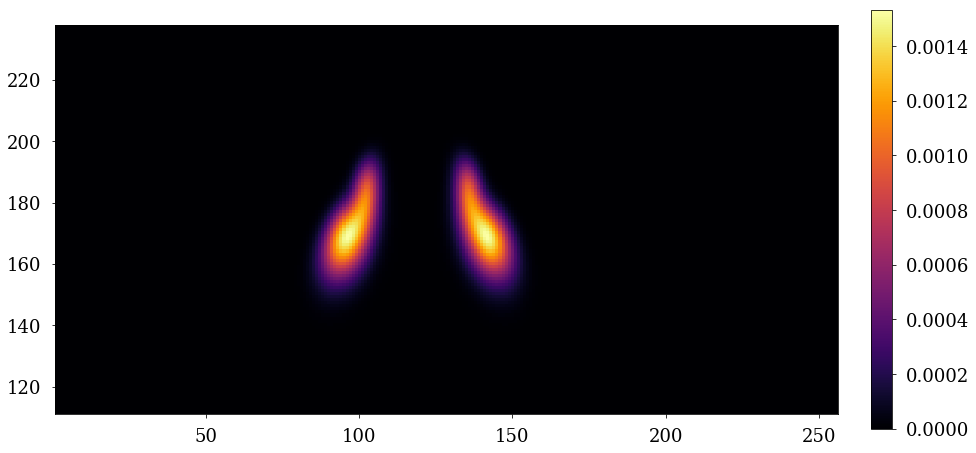

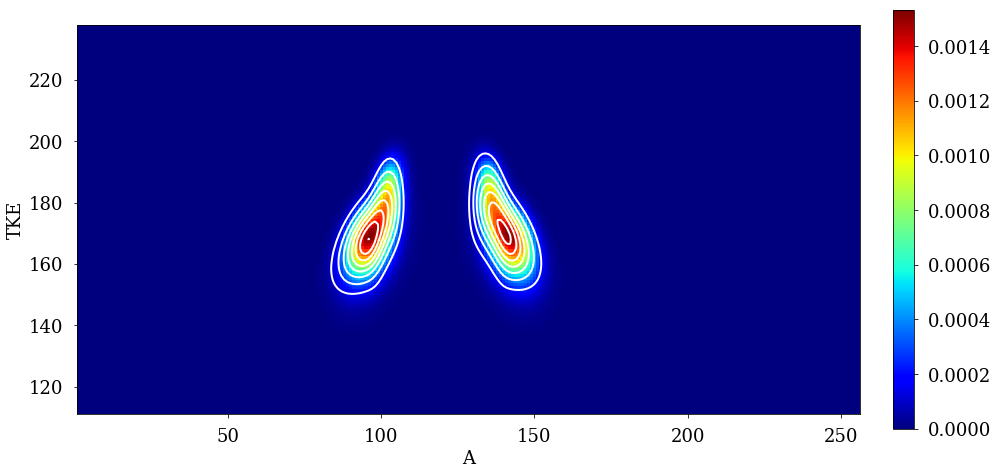

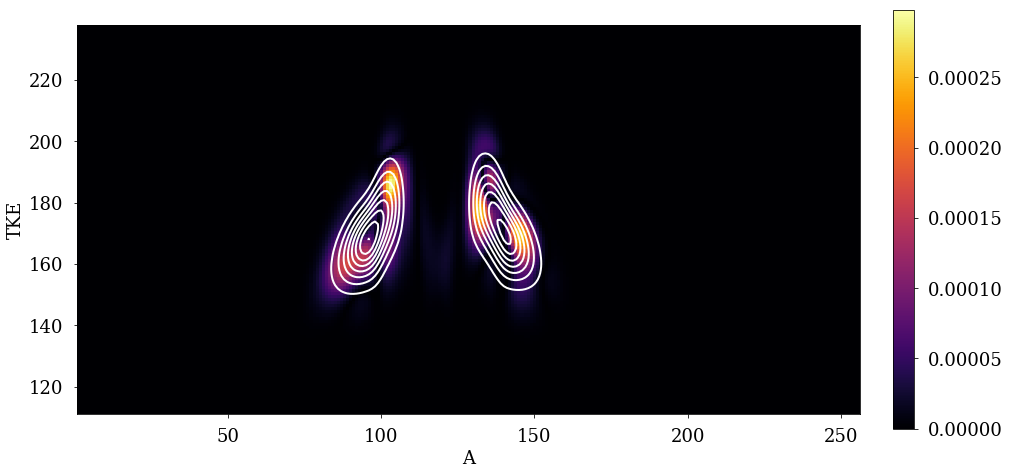

[  1.07942474e+02  -2.97277338e+00   2.08741674e-01   9.74548040e+01
   6.49752349e+00   7.39651093e-01   7.49168713e+03   5.55212964e+02
   3.04819741e+00] 
 [ inf  inf  inf  inf  inf  inf  inf  inf  inf]


In [100]:
#plot



fig, axes = pl.subplots(1, 1, figsize=(15, 10))
plt.imshow(np.transpose(YATKE_data_U235_sum.reshape(256, 128)), extent=[1,256, 111,238], origin="lower")
plt.colorbar(fraction=0.025, pad=0.04)

                     
fig, ax = pl.subplots(1, 1, figsize=(15, 10))

plt.imshow(np.transpose(YATKE_data_U235_sum.reshape(256, 128)), cmap=plt.cm.jet, origin='bottom',
    extent=(A.min(), A.max(), TKE.min(), TKE.max()))
ax.contour(A, TKE, np.transpose(data_fitted.reshape(256, 128)), 8, colors='w')
plt.xlabel('A')
plt.ylabel('TKE')
plt.colorbar(fraction=0.025, pad=0.04)


#plot residuals
fig, ax = pl.subplots(1, 1, figsize=(15, 10))
residuals = np.zeros(len(YATKE_data_U235_sum))
for i in range(len(YATKE_data_U235_sum)):
    if YATKE_data_U235_sum[i] > 0.0: 
        residuals[i] = np.abs(YATKE_data_U235_sum[i] - data_fitted[i])
plt.imshow(np.transpose(residuals.reshape(256, 128)), origin='bottom',
    extent=(A.min(), A.max(), TKE.min(), TKE.max()))
ax.contour(A, TKE, np.transpose(data_fitted.reshape(256, 128)), 8, colors='w')
plt.xlabel('A')
plt.ylabel('TKE')

plt.colorbar(fraction=0.025, pad=0.04)


plt.show()

sigma=np.sqrt(np.diag(pcov))

print(popt,'\n',sigma)  

In [96]:
print(max(residuals))

0.000297908886687
